Xgboost - uni/multi-variate analysis 

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import statsmodels.api as sm
from scipy import stats
from plotly import tools
import plotly.figure_factory as ff
import plotly.tools as tls
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-whitegrid")

In [3]:
# load and plot the time series dataset
from pandas import read_csv
#from matplotlib import pyplot
# forecast temperature with xgboost
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from matplotlib import pyplot
import numpy as np

In [4]:
df = read_csv('StockPrice_LT selection.csv',header=0, index_col=0)
values = df.values

In [5]:
values

array([[102.85],
       [102.45],
       [104.75],
       [104.9 ],
       [103.75],
       [108.25],
       [107.  ],
       [109.55],
       [109.75],
       [112.4 ],
       [110.  ],
       [114.35],
       [117.4 ],
       [118.2 ],
       [117.5 ],
       [117.1 ],
       [116.3 ],
       [116.25],
       [116.45],
       [116.35],
       [113.7 ],
       [115.2 ],
       [115.65],
       [119.65],
       [120.15],
       [118.9 ],
       [117.3 ],
       [121.55],
       [121.  ],
       [122.3 ],
       [121.45],
       [122.7 ],
       [122.7 ],
       [121.75],
       [121.5 ],
       [120.85],
       [120.1 ],
       [121.7 ],
       [122.65],
       [123.2 ],
       [123.45],
       [123.8 ],
       [123.85],
       [123.45],
       [120.7 ],
       [121.95],
       [124.95],
       [123.75],
       [121.65],
       [123.15],
       [124.1 ],
       [125.75],
       [127.1 ],
       [126.35],
       [128.1 ],
       [128.4 ],
       [127.4 ],
       [127.6 ],
       [127.25

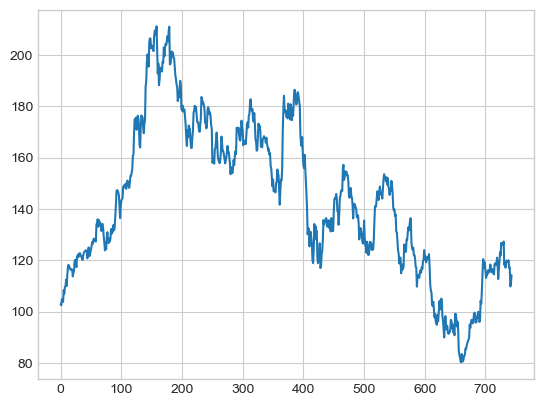

In [6]:
pyplot.plot(values)
pyplot.show()

In [7]:
#Series_to_supervised ()
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[0]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [8]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [9]:
# fit an xgboost model and make a one step forecasting
def xgboost_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict(asarray([testX]))
    return yhat[0]

Walk-forward validation 

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def walk_forward_validation(data, n_test):
    predictions = []
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = xgboost_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('> expected=%.1f, predicted=%.1f' % (testy, yhat))
    
    # calculate error metrics
    error = mean_absolute_error(test[:, -1], predictions)
    mse = mean_squared_error(test[:, -1], predictions)
    rmse = np.sqrt(mse)
    
    return error, rmse, mse, test[:, -1], predictions


In [11]:
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
data

array([[102.85, 102.45, 104.75, ..., 103.75, 108.25, 107.  ],
       [102.45, 104.75, 104.9 , ..., 108.25, 107.  , 109.55],
       [104.75, 104.9 , 103.75, ..., 107.  , 109.55, 109.75],
       ...,
       [119.9 , 119.4 , 119.25, ..., 117.05, 117.15, 109.8 ],
       [119.4 , 119.25, 119.95, ..., 117.15, 109.8 , 111.05],
       [119.25, 119.95, 117.05, ..., 109.8 , 111.05, 114.15]])

> expected=119.1, predicted=117.1
> expected=117.1, predicted=120.6
> expected=119.0, predicted=113.6
> expected=119.9, predicted=120.2
> expected=119.4, predicted=119.1
> expected=119.2, predicted=119.2
> expected=120.0, predicted=121.0
> expected=117.0, predicted=120.0
> expected=117.2, predicted=116.7
> expected=109.8, predicted=112.0
> expected=111.0, predicted=110.0
> expected=114.2, predicted=111.5
MAE: 5.798
RMSE: 1.840
MSE: 2.408


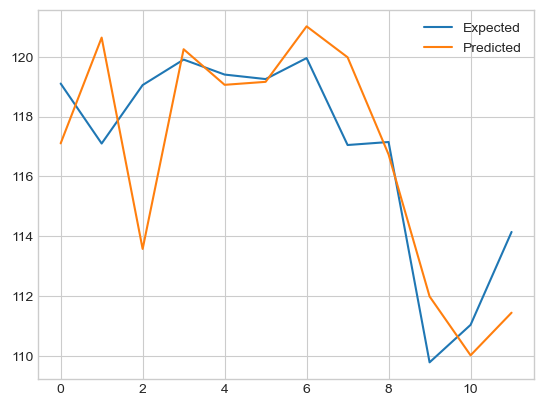

In [12]:
# evaluate
rmse, mse, mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)
print('RMSE: %.3f' % rmse)
print('MSE: %.3f' % mse)

# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

In [13]:
preds = []
for i in range(10):
    # transform the time series data into supervised learning
    train = series_to_supervised(values, n_in=6)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(trainX, trainy)
    # construct an input for a new preduction
    row = values[-6:].flatten()
    # make a one-step prediction
    yhat = model.predict(asarray([row]))
    print('Input: %s, Forecast: %.3f' % (row, yhat[0]))
    values = np.append(values, yhat)
    preds.append(yhat)

Input: [119.95 117.05 117.15 109.8  111.05 114.15], Forecast: 113.737
Input: [117.05       117.15       109.8        111.05       114.15
 113.73679352], Forecast: 114.230
Input: [117.15       109.8        111.05       114.15       113.73679352
 114.23014069], Forecast: 115.252
Input: [109.8        111.05       114.15       113.73679352 114.23014069
 115.25179291], Forecast: 116.245
Input: [111.05       114.15       113.73679352 114.23014069 115.25179291
 116.24456787], Forecast: 115.641
Input: [114.15       113.73679352 114.23014069 115.25179291 116.24456787
 115.64089203], Forecast: 117.374
Input: [113.73679352 114.23014069 115.25179291 116.24456787 115.64089203
 117.37449646], Forecast: 116.582
Input: [114.23014069 115.25179291 116.24456787 115.64089203 117.37449646
 116.58169556], Forecast: 117.785
Input: [115.25179291 116.24456787 115.64089203 117.37449646 116.58169556
 117.7851944 ], Forecast: 117.865
Input: [116.24456787 115.64089203 117.37449646 116.58169556 117.7851944
 117.865

Input: [115.64089203 117.37449646 116.58169556 117.7851944  117.86512756
 120.76591492], Forecast: 119.840
Input: [117.37449646 116.58169556 117.7851944  117.86512756 120.76591492
 119.83959961], Forecast: 119.515
Input: [116.58169556 117.7851944  117.86512756 120.76591492 119.83959961
 119.51537323], Forecast: 119.478
Input: [117.7851944  117.86512756 120.76591492 119.83959961 119.51537323
 119.47820282], Forecast: 119.438
Input: [117.86512756 120.76591492 119.83959961 119.51537323 119.47820282
 119.4375    ], Forecast: 118.441
Input: [120.76591492 119.83959961 119.51537323 119.47820282 119.4375
 118.44127655], Forecast: 115.563
Input: [119.83959961 119.51537323 119.47820282 119.4375     118.44127655
 115.56336975], Forecast: 114.672
Input: [119.51537323 119.47820282 119.4375     118.44127655 115.56336975
 114.67154694], Forecast: 115.420
Input: [119.47820282 119.4375     118.44127655 115.56336975 114.67154694
 115.42012787], Forecast: 115.267
Input: [119.4375     118.44127655 115.563

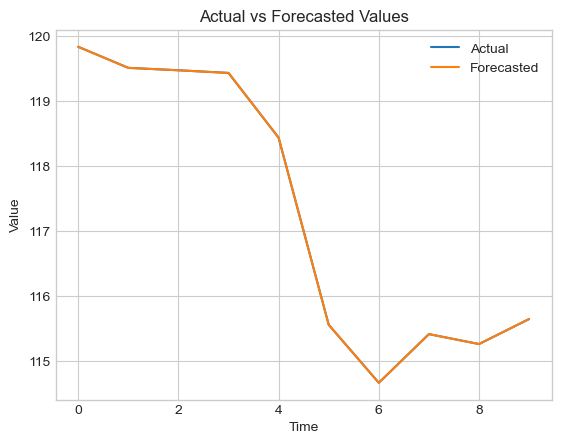

In [14]:
import matplotlib.pyplot as plt

# Your code snippet
preds = []
for i in range(10):
    # transform the time series data into supervised learning
    train = series_to_supervised(values, n_in=6)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(trainX, trainy)
    # construct an input for a new preduction
    row = values[-6:].flatten()
    # make a one-step prediction
    yhat = model.predict(np.asarray([row]))
    print('Input: %s, Forecast: %.3f' % (row, yhat[0]))
    values = np.append(values, yhat)
    preds.append(yhat)

# Plotting
actual_values = values[-10:]
plt.plot(actual_values, label='Actual')
plt.plot(preds, label='Forecasted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs Forecasted Values')
plt.legend()
plt.show()